***Task Overview***

As a researcher, I would like to find out the impact from contentious parameters (`market.liquidity.probabilityOfTrading.tau.scaling`), so that I can set a reasonable default value for them.

`market.liquidity.probabilityOfTrading.tau.scaling` is a scaling parameter which is used to scale $\tau$ in risk model in calculation of probability of trading calculation so to eventually adjust the pegged volume for liquidity provider. 

Change of `market.liquidity.probabilityOfTrading.tau.scaling` will immediately change the scaling parameter for $\tau$
, hence will change the probability of trading in LP orders, as well as the margin requirement of the LPs, and eventually change the PnL of the LPs. 

***Input Metrics***

- simulated market is **ETH/USD** with market decimal place **mdp = 3**, asset decimal place **adp = 5** and position decimal place **pdp = 2**

- initial mid-price of **ETH/USD** is **$1123.11** (the average price on 15/06/2022)

- run **Trials=5** trials for each test

- each trial has **Time = 86400 s = 24 h** with interval of **5 min**

- target simulated daily traded notional is **$694,928,100.62**

- LP commitment is set to be a reasonable constant number in the simulation to avoid liquidity auction

- network parameter `market.liquidity.probabilityOfTrading.tau.scaling` is set to be [1, 10, 100]


***Output Metrics***

Under different network parameter `market.liquidity.probabilityOfTrading.tau.scaling`:

- Output 1: LP postion

- Output 2: average of LP margin account

- Output 3: average of LP bond account

- Output 4: average of LP's **general PnL** 

- Output 5: average of **traded notional**

- Output 6: average of market **open interest**

- Output 7: average of **target stake** of market 


### A comparison with the result from 'IdealMarketMakerV2'

In [1]:
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../../../vega-market-sim/vega_sim/parameter_test/')
from parameter.experiment import FILE_PATTERN, FILE_PATTERN_LOB

with open('run_config.json') as d:
    setting = json.load(d)

num_of_paravalues = len(setting['tested_values'])

data = []

for _ in range(num_of_paravalues):
    file_path = FILE_PATTERN.format(
        param_name=setting['parameter_tested'], param_value=setting['tested_values'][_]
    )
    data.append(pd.read_csv(file_path))

# if number of sim under each parameter is larger than 1
if setting['num_runs'] > 1:
    data_ave = []
    for _ in range(num_of_paravalues):
        data_ave.append(data[_].groupby(data[_]["Time Step"]).mean())
else:
    data_ave =[]
    for _ in range(num_of_paravalues):
        data_ave.append(data[_].set_index(data[_]['Time Step']))      

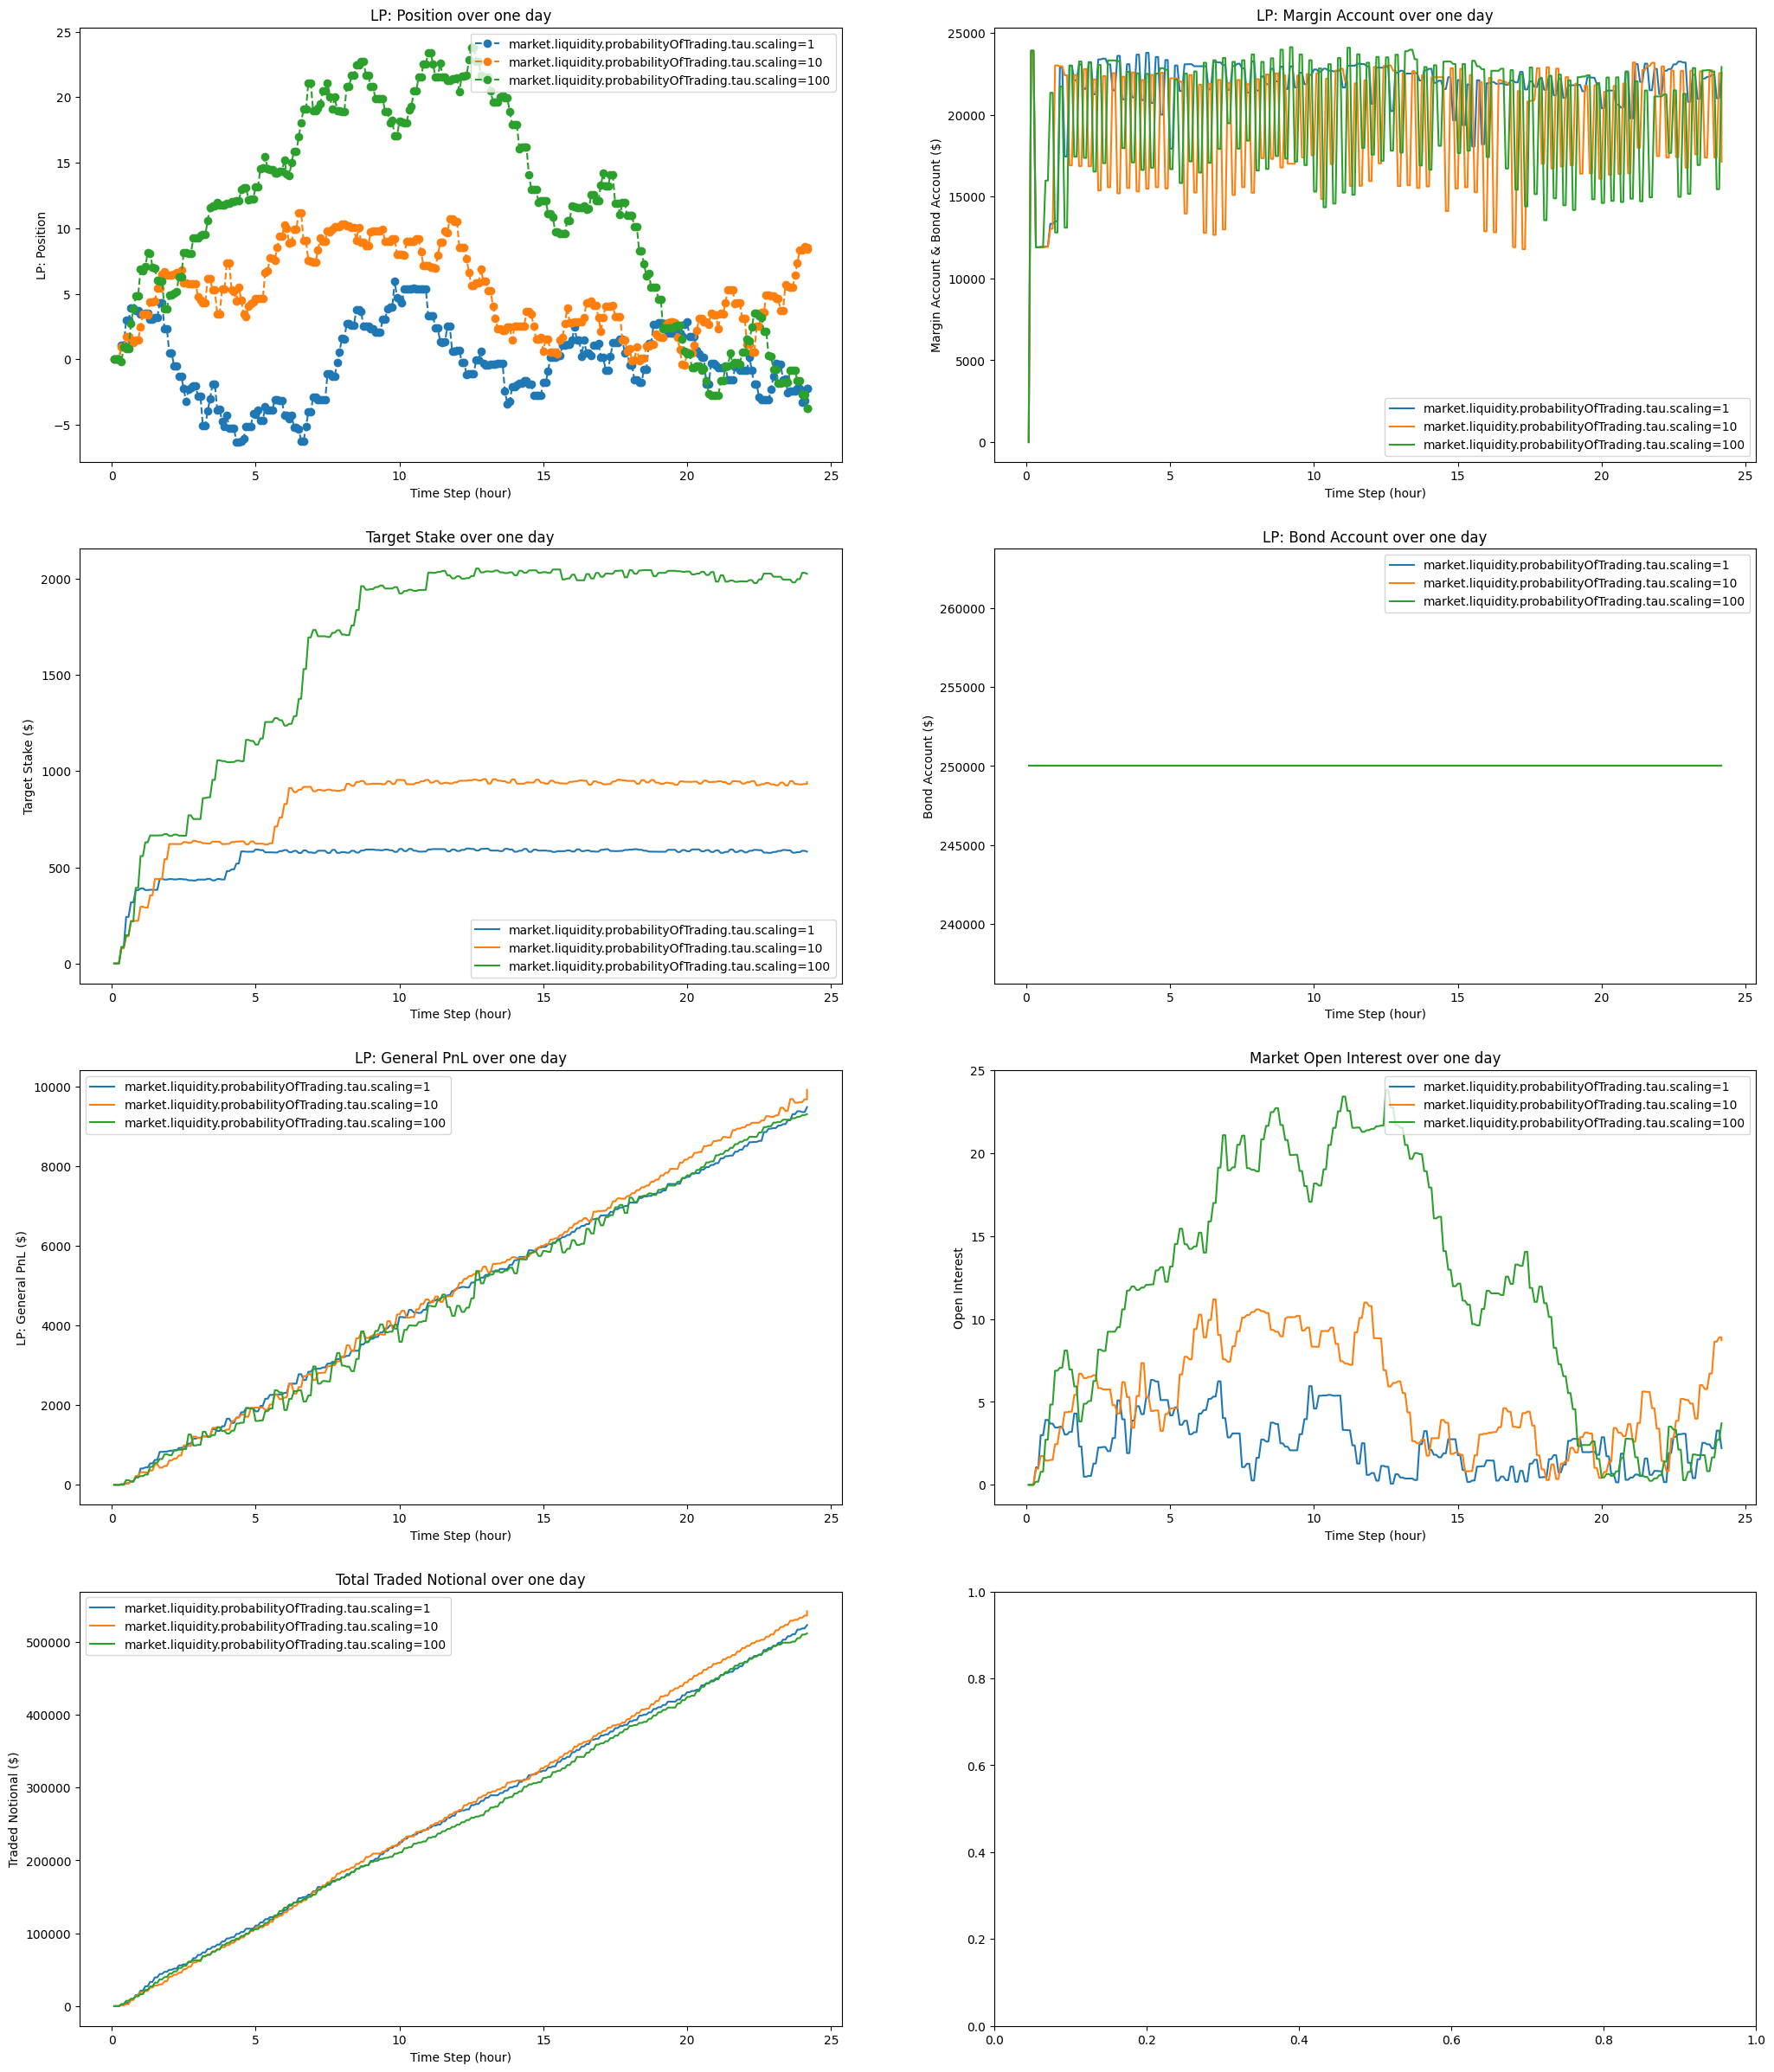

In [2]:
# Plot the optimal strategy
fig,ax = plt.subplots(4,2,figsize=(25,30))

# Since the interval of sim is 5 min
dt = 5 / 60


# Plot LP: Position over one day
for _ in range(num_of_paravalues):
    ax[0,0].plot(data_ave[_].index * dt,data[_][data[_]['Iteration'] == 0]['LP: Position'],'o--',label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
# ax[0,0].plot(ave_tau_1.index * dt,data_tau_1['LP: Position'],'o--',label="tauscaling=1")
# ax[0,0].plot(ave_tau_10.index * dt,data_tau_10['LP: Position'],'o--',label="tauscaling=10")
# ax[0,0].plot(ave_tau_100.index * dt,data_tau_100['LP: Position'],'o--',label="tauscaling=100")
ax[0,0].set_title('LP: Position over one day')
ax[0,0].set_xlabel("Time Step (hour)")
ax[0,0].set_ylabel("LP: Position")
ax[0,0].legend()

# Plot LP: Margin Account 
for _ in range(num_of_paravalues):
    ax[0,1].plot(data_ave[_].index * dt,data_ave[_]['LP: Margin Account'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[0,1].set_title('LP: Margin Account over one day')
ax[0,1].set_xlabel("Time Step (hour)")
ax[0,1].set_ylabel("Margin Account & Bond Account ($)")
ax[0,1].legend()

# Bond Account
for _ in range(num_of_paravalues):
    ax[1,1].plot(data_ave[_].index * dt,data_ave[_]['LP: Bond Account'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[1,1].set_title('LP: Bond Account over one day')
ax[1,1].set_xlabel("Time Step (hour)")
ax[1,1].set_ylabel("Bond Account ($)")
ax[1,1].legend()

# Plot target stake in market
for _ in range(num_of_paravalues):
    ax[1,0].plot(data_ave[_].index * dt,data_ave[_]['Target Stake'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[1,0].set_title('Target Stake over one day')
ax[1,0].set_xlabel("Time Step (hour)")
ax[1,0].set_ylabel("Target Stake ($)")
ax[1,0].legend()

# Plot LP: General PnL
for _ in range(num_of_paravalues):
    ax[2,0].plot(data_ave[_].index * dt,data_ave[_]['LP: GeneralPnl'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[2,0].set_title('LP: General PnL over one day')
ax[2,0].set_xlabel("Time Step (hour)")
ax[2,0].set_ylabel("LP: General PnL ($)")
ax[2,0].legend()

# Plot Market Open Interest
for _ in range(num_of_paravalues):
    ax[2,1].plot(data_ave[_].index * dt,data_ave[_]['Market Open Interest'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[2,1].set_title('Market Open Interest over one day')
ax[2,1].set_xlabel("Time Step (hour)")
ax[2,1].set_ylabel("Open Interest")
ax[2,1].legend()

# Plot Total Traded Notional
for _ in range(num_of_paravalues):
    ax[3,0].plot(data_ave[_].index * dt,data_ave[_]['Total Traded Notional'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[3,0].set_title('Total Traded Notional over one day')
ax[3,0].set_xlabel("Time Step (hour)")
ax[3,0].set_ylabel("Traded Notional ($)")
ax[3,0].legend()

plt.show()

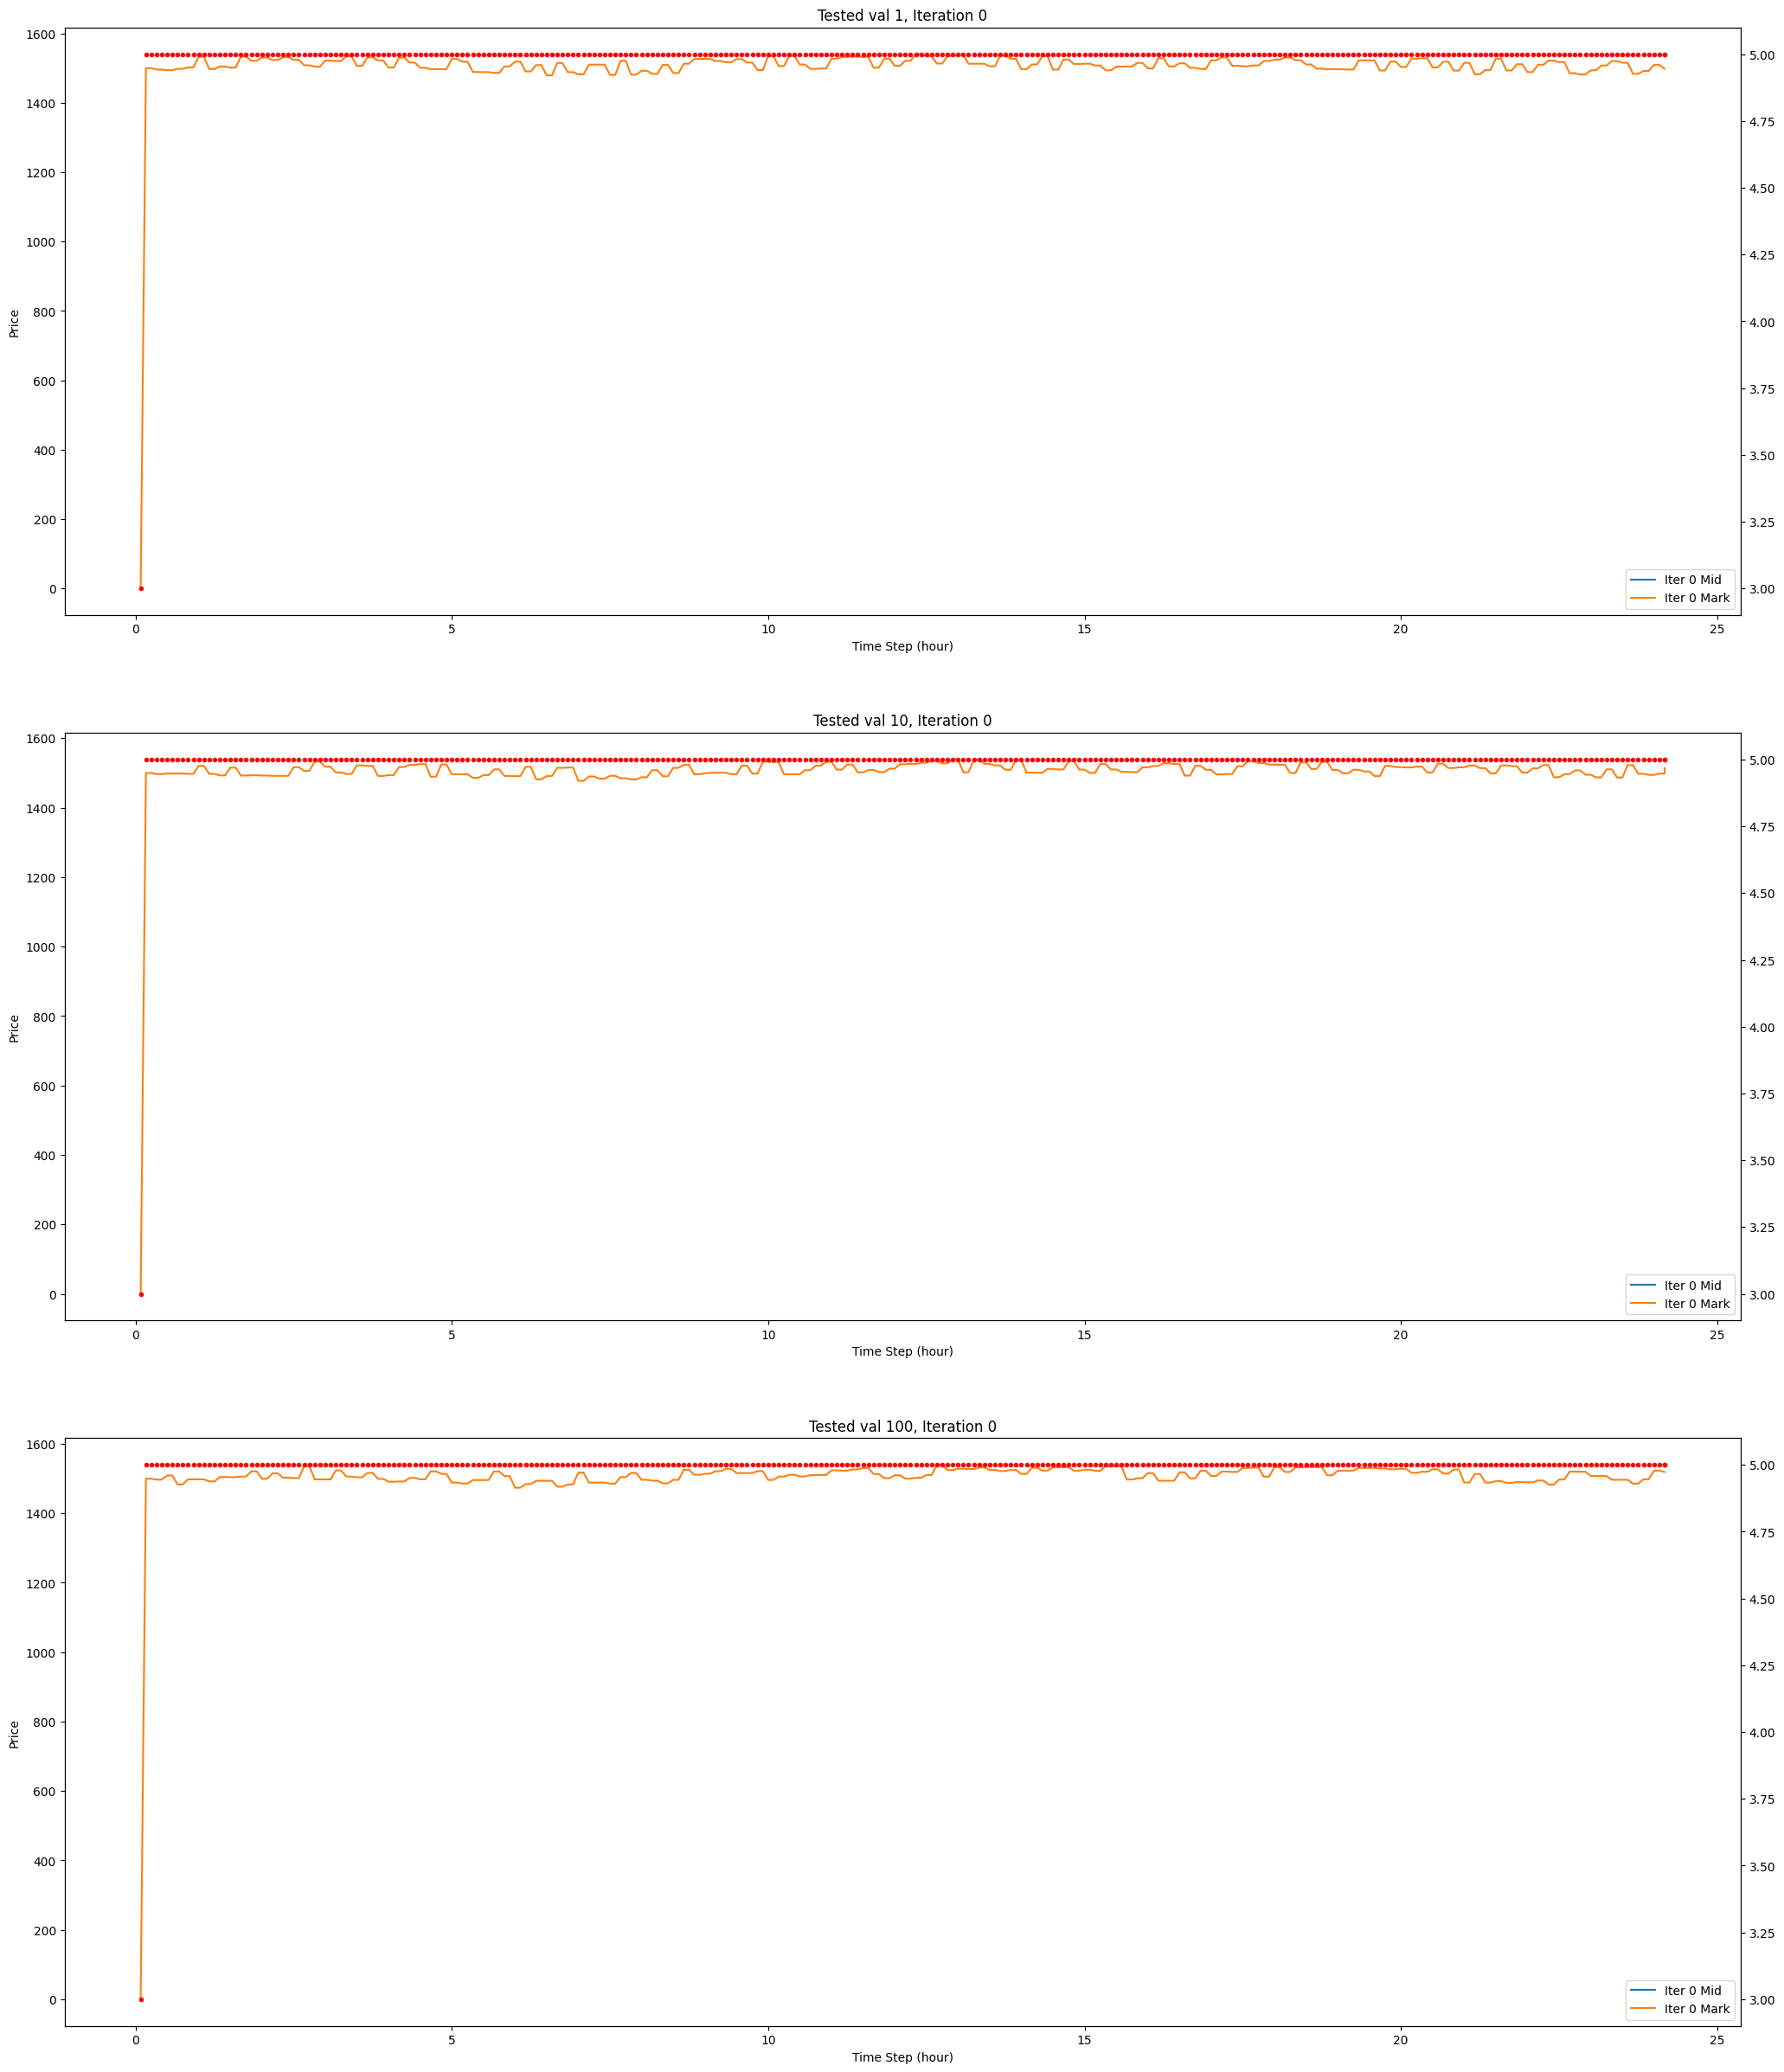

In [3]:
rows = len(setting['tested_values'])
cols = max(data[0]['Iteration'])+1
fig,ax = plt.subplots(rows,cols,figsize=(25,30))

if cols > 1:
    for data_index in range(0,rows):
        for iter_num, iter_df in data[data_index].groupby('Iteration'):
            ax[data_index,iter_num].plot(data_ave[data_index].index * dt, iter_df['External Midprice'],'--',label=f"Iter {iter_num} External Mid")
            ax[data_index,iter_num].plot(data_ave[data_index].index * dt, iter_df['Markprice'], label=f"Iter {iter_num} Mark")
            ax[data_index,iter_num].legend()
            ax[data_index,iter_num].set_title('Tested val ' + str(setting['tested_values'][data_index]) +', Iteration '+str(iter_num))
            ax[data_index,iter_num].set_xlabel("Time Step (hour)")
            ax[data_index,iter_num].set_ylabel("Price")
            
            ax2 = ax[data_index,iter_num].twinx()
            ax2.plot(data_ave[data_index].index * dt, iter_df['Market State'], '.', color='red', label=f"Iter {iter_num} State")
else:
        for data_index in range(0,rows):
            for iter_num, iter_df in data[data_index].groupby('Iteration'):
                ax[data_index].plot(data_ave[data_index].index * dt, iter_df['External Midprice'], label=f"Iter {iter_num} Mid")
                ax[data_index].plot(data_ave[data_index].index * dt, iter_df['Markprice'], label=f"Iter {iter_num} Mark")
                ax[data_index].legend()
                ax[data_index].set_title('Tested val ' + str(setting['tested_values'][data_index]) +', Iteration '+str(iter_num))
                ax[data_index].set_xlabel("Time Step (hour)")
                ax[data_index].set_ylabel("Price")
                
                ax2 = ax[data_index].twinx()
                ax2.plot(data_ave[data_index].index * dt, iter_df['Market State'], '.', color='red', label=f"Iter {iter_num} State")


In [4]:
# Plot LOB
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Choosing which sim to plot: Test value & Iteration
values = [int(i) for i in setting['tested_values']]
param_value = widgets.Dropdown(
    options=values,
    value=values[0],
    description='Param_val:',
    disabled=False,
)

iteration = [i for i in range(setting['num_runs'])]
Iteration = widgets.Dropdown(
    options=iteration,
    value=iteration[0],
    description='Iteration:',
    disabled=False,
)
display(widgets.HBox([param_value, Iteration]))

In [5]:
file_path_LOB = FILE_PATTERN_LOB.format(
    param_name=setting['parameter_tested'], param_value=param_value.value,
)

file_path = FILE_PATTERN.format(
    param_name=setting['parameter_tested'], param_value=param_value.value,
)

data = pd.read_csv(file_path_LOB)
data = data[data['Iteration'] == Iteration.value]

# Log midprice info
data_mid = pd.read_csv(file_path)
data_mid = data_mid[data_mid['Iteration'] == Iteration.value]

new_data_list = []

for i in range(data.shape[0]):
    res_bid = data['Order Book Bid Side'].iloc[i]
    res_ask = data['Order Book Ask Side'].iloc[i]
    time_step = data['Time Step'].iloc[i]
    res_bid = res_bid[1:-1]
    res_bid = res_bid.split(', ')
    res_ask = res_ask[1:-1]
    res_ask = res_ask.split(', ')
    for _ in range(len(res_bid)):
        tmp = res_bid[_].split(': ')
        if len(tmp) == 2:
            result = {}
            result['Time Step'] = time_step
            result['Price'] = float(tmp[0])
            result['Volume'] = float(tmp[1])
            result['Side'] = 'Bid'
            new_data_list.append(result)

    for _ in range(len(res_ask)):
        tmp = res_ask[_].split(': ')
        if len(tmp) == 2:
            result = {}
            result['Time Step'] = time_step
            result['Price'] = float(tmp[0])
            result['Volume'] = float(tmp[1])
            result['Side'] = 'Ask'
            new_data_list.append(result)
    if time_step != 289:
        result = {}
        result['Time Step'] = time_step
        result['Price'] = data_mid.loc[time_step,'External Midprice']
        result['Side'] = 'Mid'
        result['Volume'] = 0.05
        new_data_list.append(result)

df = pd.DataFrame(new_data_list)

fig = px.bar(df,
             y="Price",
             x="Volume",
             animation_frame="Time Step",
             orientation='h',
             color="Side",   
             color_discrete_map={
                'Bid': 'red',
                'Ask': 'blue',
                'Mid': 'black'
            },
            pattern_shape='Side',
            pattern_shape_map={
                'Bid': '/',
                'Ask': '/',
                'Mid': '.',
            },
            range_x=[0, 2],
            base='Side',
    )
# improve aesthetics (size, grids etc.)
fig.update_layout(width=800,
                  height=800,
                  xaxis_showgrid=True,
                  yaxis_showgrid=True,
                  plot_bgcolor='rgba(0,0,0,0)',
                  title_text=f'LOB of Tested val {param_value.value}, iteration {Iteration.value}',
                  showlegend=True,
    )

fig.update_traces(width=0.001)
fig.update_xaxes(title_text='Volume')
fig.update_yaxes(title_text='Price')
fig.show()

In [6]:
# 3D plot of LOB
fig = px.scatter_3d(
  df,
  x="Price",
  y="Time Step",
  z="Volume",
  color="Side",
  size="Volume",
)

fig.update_layout(
  title="3D LOB",
  autosize=False,
  width=1000,
  height=1000,
)

fig.show()

In [7]:
import plotly.graph_objects as go
import pandas as pd

# Read data from a csv
fig = go.Figure(data=[go.Surface(z=df.Price.values.reshape(max(df['Time Step']), -1), y=df['Time Step'].unique())])

fig.update_layout(title='Order Book Depth', autosize=False,
                  width=700, height=700,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

ValueError: cannot reshape array of size 12330 into shape (290,newaxis)

In [ ]:
# 3D bar chart of LOB
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)

price_step = np.arange(df['Price'].min(),df['Price'].max(),0.001)
column = ['Time Step'] + list(np.round(price_step,3))

trans_bid = []
trans_ask = []

for i in range(data.shape[0]):
    dict_bid = dict(zip(column,[data['Time Step'].iloc[i]] + [0]*len(price_step)))
    dict_ask = dict(zip(column,[data['Time Step'].iloc[i]] + [0]*len(price_step)))

    res_bid = data['Order Book Bid Side'].iloc[i]
    res_ask = data['Order Book Ask Side'].iloc[i]

    res_bid = res_bid[1:-1]
    res_bid = res_bid.split(', ')
    res_ask = res_ask[1:-1]
    res_ask = res_ask.split(', ')

    for _ in range(len(res_bid)):
        tmp = res_bid[_].split(': ')
        if len(tmp) == 2:
            dict_bid[round(float(tmp[0]),3)] = round(float(tmp[1]),2)
            
    for _ in range(len(res_ask)):
        tmp = res_ask[_].split(': ')
        if len(tmp) == 2:
            dict_ask[round(float(tmp[0]),3)] = round(float(tmp[1]),2)

    trans_bid.append(dict_bid)
    trans_ask.append(dict_ask)

data_bid = pd.DataFrame(trans_bid)
data_bid = data_bid.loc[:, (data_bid != 0).any(axis=0)]
data_ask = pd.DataFrame(trans_ask)
data_ask = data_ask.loc[:, (data_ask != 0).any(axis=0)]

In [ ]:
# Plot 3D LOB with bar plot
set = 0

time_step = np.arange(1,33) + 32 * set
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Price')
ax.set_ylabel('Time Step')
ax.set_zlabel('Volume')
ax.set_yticks(time_step)

data_set = data_bid.iloc[time_step[0]-1:time_step[-1],:]
data_set = data_set.loc[:, (data_set != 0).any(axis=0)]
data_set = data_set.dropna(axis=1,how='any')

for step in time_step:
  xs = list(data_set.columns[1:])
  ys = list(data_set.iloc[step-32*set-1, 1:])
  # Plot the 3D bar graph given by xs and ys 
  ax.bar(xs, ys, zs=step, zdir='y',color='red',width=0.07)

data_set = data_ask.iloc[time_step[0]-1:time_step[-1],:]
data_set = data_set.loc[:, (data_set != 0).any(axis=0)]
data_set = data_set.dropna(axis=1,how='any')

for step in time_step:
  xs = list(data_set.columns[1:])
  ys = list(data_set.iloc[step-32*set-1, 1:])
  # Plot the 3D bar graph given by xs and ys 
  ax.bar(xs, ys, zs=step, zdir='y',color='blue',width=0.04)

plt.show()